# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 4.1 Importing libraries

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import time
import torch
# import utilities to keep workspaces alive during model training
from workspace_utils import active_session
from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment


### 4.2 Setting parameters

# The chosen hyperparameters Hyperparameters
 
BUFFER_SIZE = int(4e5)          # Replay buffer size </br>

BATCH_SIZE = 256               # Minibatch size </br>

GAMMA = 0.99                    # Discount factor </br>

TAU = 2e-3                      # For soft update of target parameters </br>

LR_ACTOR = 2e-4                 # Learning rate of the actor </br>

LR_CRITIC = 6e-4                # Learning rate of the critic </br>

WEIGHT_DECAY = 0                # L2 weight decay </br>

OU_SIGMA = 0.01                  # Ornstein-Uhlenbeck noise parameter, volatility </br>

OU_THETA = 0.15                 # Ornstein_Uhlenbeck noise parameter, speed of mean reversion </br>




 Suggested on slack: </br>
 
LEARN_EVERY = 20        # learning timestep interval </br>

LEARN_NUM   = 10        # number of learning passes </br>

GRAD_CLIPPING = 1.0     # Gradient Clipping </br>


EPSILON       = 1.0     # for epsilon in the noise process (act step) </br>

EPSILON_DECAY = 1e-6 </br>


### 4.3 Training loop

# Model architecture
Similar to single-agent Actor Critic architecture, each agent has it’s own actor and critic network. The actor network takes in the current state of agent and output a recommended action for that agent. However the critic part is slightly different from ordinary single-agent DDPG. Here the critic network of each agent has full visibility on the environment. It not only takes in the observation and action of that particular agent, but also observations and actions of all other agents as well. Critic network has much higher visibility on what is happening while actor network can only access to the observation information of the respective agent. The output of the critic network is, nevertheless, still the Q value estimated given a full observation input(all agents) and a full action input(all agents). The output of the actor network is a recommended action for that particular agent.


# class Actor(nn.Module): """Actor (Policy) Model."""

def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
    """Initialize parameters and build model.
    Params
    ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fc1_units (int): Number of nodes in first hidden layer
        fc2_units (int): Number of nodes in second hidden layer
    """
    super(Actor, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.bn1 = nn.BatchNorm1d(fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.fc3 = nn.Linear(fc2_units, action_size)
    self.reset_parameters()

def reset_parameters(self):
    self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
    self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
    self.fc3.weight.data.uniform_(-3e-3, 3e-3)

def forward(self, state):
    """Build an actor (policy) network that maps states -> actions."""
    x = F.relu(self.bn1(self.fc1(state)))
    x = F.relu(self.fc2(x))
    return torch.tanh(self.fc3(x))


# class Critic(nn.Module): """Critic (Value) Model."""

def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
    """Initialize parameters and build model.
    Params
    ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fcs1_units (int): Number of nodes in the first hidden layer
        fc2_units (int): Number of nodes in the second hidden layer
    """
    super(Critic, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.bn1 = nn.BatchNorm1d(fc1_units)
    self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
    self.fc3 = nn.Linear(fc2_units, 1)
    self.reset_parameters()

def reset_parameters(self):
    self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
    self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
    self.fc3.weight.data.uniform_(-3e-3, 3e-3)

def forward(self, state, action):
    """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
    xs = F.relu(self.bn1(self.fc1(state)))
    x = torch.cat((xs, action), dim=1)
    x = F.relu(self.fc2(x))
    return self.fc3(x)

### 4.4 Train the Agent with MADDPG

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=9)


In [9]:
def ddpg(n_episodes=2500, max_t=1000, print_every=10):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    mean_scores = []                               # list of mean scores from each episode
    moving_avgs = []                               # list of moving averages
    best_score  = -np.inf
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}'.format(\
                  i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))  
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return mean_scores, moving_avgs

In [10]:
with active_session():
    scores, avgs = ddpg()

Episode 10 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 20 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 30 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 40 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 50 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 60 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 70 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 80 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 90 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 100 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 110 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 120 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 130 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 140 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 150 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 160 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 170 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 180 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 190 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 200 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 210 (1s)	Mean: 0.0	Moving Avg: -0.0
Episode 220 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 230 (1s)	Mea

### 4.4 Reward Plot

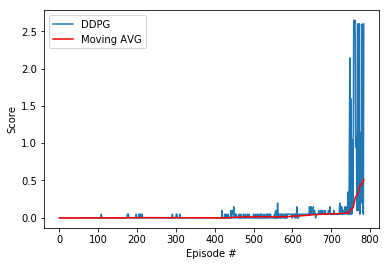

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

When finished, you can close the environment.

In [12]:
env.close()

### 4.5 Ideas for improving the agent's performance
Batch Normalization
Neural network enhancement for a better performance.